| Algorithm               | Key Idea                              | When to Use                         |
| ----------------------- | ------------------------------------- | ----------------------------------- |
| **K-Means**             | Assign points to k centroids          | Fast, widely used                   |
| **DBSCAN**              | Group by density of points            | Detects outliers, arbitrary shapes  |
| **Agglomerative**       | Merge closest clusters hierarchically | Good for small datasets, dendrogram |
| **Spectral Clustering** | Use graph structure (eigenvectors)    | Good for non-convex shapes          |
| **Gaussian Mixture**    | Soft probabilistic clustering         | When clusters may overlap           |


# KMeans

| Use **K-Means** when:                       |
| ------------------------------------------- |
| You want fast, flat clustering              |
| You know the number of clusters (`k`)       |
| Your data roughly fits **spherical groups** |


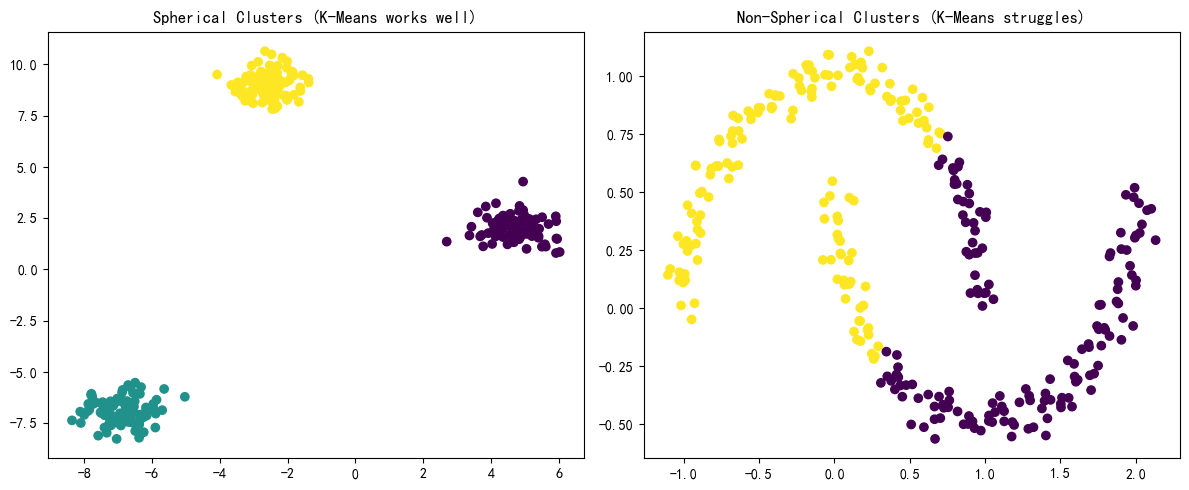

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans
from matplotlib import gridspec

# Generate spherical data (good for K-Means)
X_spherical, _ = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=42)

# Generate non-spherical data (bad for K-Means)
X_moons, _ = make_moons(n_samples=300, noise=0.05, random_state=42)

# Apply K-Means
kmeans_spherical = KMeans(n_clusters=3, random_state=42).fit_predict(X_spherical)
kmeans_moons = KMeans(n_clusters=2, random_state=42).fit_predict(X_moons)

# Plot
fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 2)

# Spherical clusters
ax0 = fig.add_subplot(gs[0, 0])
ax0.scatter(X_spherical[:, 0], X_spherical[:, 1], c=kmeans_spherical, cmap='viridis')
ax0.set_title("Spherical Clusters (K-Means works well)")

# Non-spherical clusters
ax1 = fig.add_subplot(gs[0, 1])
ax1.scatter(X_moons[:, 0], X_moons[:, 1], c=kmeans_moons, cmap='viridis')
ax1.set_title("Non-Spherical Clusters (K-Means struggles)")

plt.tight_layout()
plt.show()




| **Requirement**                  | **Explanation**                                                                              |
| -------------------------------- | -------------------------------------------------------------------------------------------- |
| **Numerical Features Only**      | K-Means uses distance metrics like Euclidean; it cannot directly handle categorical data.    |
| **Feature Scaling Recommended**  | Features should be normalized or standardized to prevent dominance by large-scale variables. |
| **Spherical Cluster Structure**  | Works best when clusters are convex, isotropic, and roughly the same size.                   |
| **Moderate Dimensionality**      | Performance degrades in high dimensions; consider dimensionality reduction (e.g., PCA).      |
| **No Strong Outliers**           | Outliers can distort centroids; remove or handle them before clustering.                     |
| **Fixed Number of Clusters (k)** | The number of clusters must be specified in advance; requires tuning or estimation.          |


| Dimensionality | Considered | Notes                                                                  |
| -------------- | ---------- | ---------------------------------------------------------------------- |
| **1–10**       | Low        | K-Means usually performs well                                          |
| **10–50**      | Moderate   | Still okay, but may need scaling and possibly dimensionality reduction |
| **> 50**       | High       | K-Means becomes less effective due to the **curse of dimensionality**  |


***What to Do if You Have Many Dimensions***
| Strategy               | Purpose                                         |
| ---------------------- | ----------------------------------------------- |
| `StandardScaler`       | Normalize feature scales (always recommended)   |
| `PCA` / `TruncatedSVD` | Reduce dimensionality while preserving variance |
| Feature selection      | Drop irrelevant or low-variance features        |


In [2]:
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [3]:
# Load Titanic dataset
df = sns.load_dataset("titanic")


In [4]:
df.sample(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
521,0,3,male,22.0,0,0,7.8958,S,Third,man,True,NaN,Southampton,no,True
339,0,1,male,45.0,0,0,35.5000,S,First,man,True,NaN,Southampton,no,True
34,0,1,male,28.0,1,0,82.1708,C,First,man,True,NaN,Cherbourg,no,False


In [6]:
df.shape

(891, 15)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [8]:
df.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
# Select useful columns for clustering
df = df[["pclass", "sex", "age", "fare", "embarked"]].dropna()

In [10]:
df.sample(3)

,pclass,sex,age,fare,embarked
788,3,male,1.0,20.5750,S
462,1,male,47.0,38.5000,S
879,1,female,56.0,83.1583,C


### Elbow Method (choose k)

In [11]:
# Separate features by type
numerical_features = ["age", "fare"]
categorical_features = ["pclass", "sex", "embarked"]

In [12]:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(), categorical_features)
])


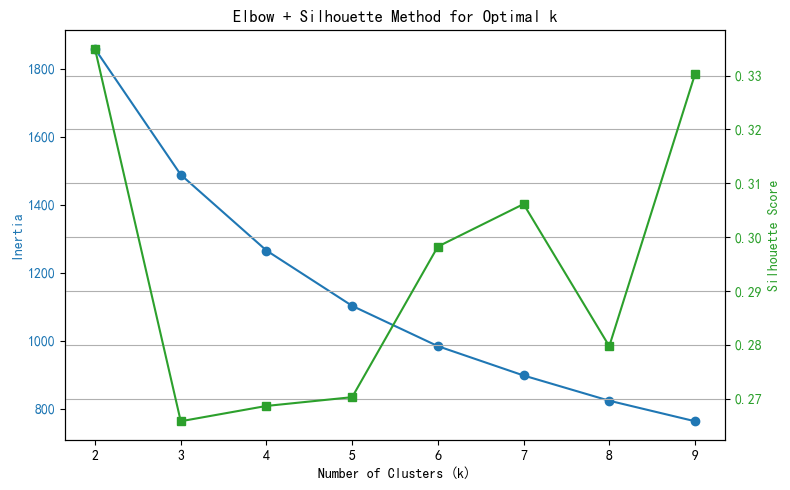

In [63]:
inertias = []
silhouette_scores = []
k_values = range(2, 10)  # silhouette_score not valid for k=1

for k in k_values:
    pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("kmeans", KMeans(n_clusters=k, random_state=42))
])

    pipeline.fit(df)
    inertias.append(pipeline.named_steps["kmeans"].inertia_)
    labels = pipeline.named_steps["kmeans"].labels_
    X_transformed = preprocessor.fit_transform(df)
    silhouette_scores.append(silhouette_score(X_transformed, labels))

# Plot both
fig, ax1 = plt.subplots(figsize=(8, 5))

color1 = 'tab:blue'
ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("Inertia", color=color1)
ax1.plot(k_values, inertias, marker='o', color=color1, label="Inertia")
ax1.tick_params(axis='y', labelcolor=color1)

# Add second y-axis for silhouette score
ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.set_ylabel("Silhouette Score", color=color2)
ax2.plot(k_values, silhouette_scores, marker='s', color=color2, label="Silhouette")
ax2.tick_params(axis='y', labelcolor=color2)

plt.title("Elbow + Silhouette Method for Optimal k")
fig.tight_layout()
plt.grid(True)
plt.show()


In [71]:
pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("kmeans", KMeans(n_clusters=7, random_state=42))
])


In [72]:
# Fit pipeline
pipeline.fit(df)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'fare']),
                                                 ('cat', OneHotEncoder(),
                                                  ['pclass', 'sex',
                                                   'embarked'])])),
                ('kmeans', KMeans(n_clusters=7, random_state=42))])

In [73]:
# Get cluster assignments
cluster_labels = pipeline.named_steps["kmeans"].labels_


In [74]:
# Reduce to 2D for visualization
X_processed = preprocessor.fit_transform(df)
X_pca = PCA(n_components=2).fit_transform(X_processed)

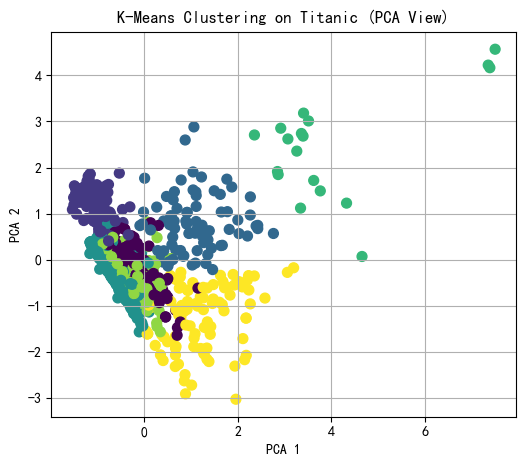

In [75]:
# Plot
plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap="viridis", s=50)
plt.title("K-Means Clustering on Titanic (PCA View)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

Since we applied a ColumnTransformer, the cluster centers are in transformed feature space, so we need to:

- Get the feature names
- View the cluster centers using those names

In [76]:
# Step 1: get feature names
feature_names = preprocessor.get_feature_names_out()

# Step 2: get cluster centers from the trained KMeans model
centers_transformed = pipeline.named_steps["kmeans"].cluster_centers_

# Step 3: make it readable
centers_df = pd.DataFrame(centers_transformed, columns=feature_names)
centers_df


,num__age,num__fare,cat__pclass_1,cat__pclass_2,cat__pclass_3,cat__sex_female,cat__sex_male,cat__embarked_C,cat__embarked_Q,cat__embarked_S
0,0.194726,-0.293417,-5.551115e-17,5.943396e-01,4.056604e-01,1.000000e+00,4.440892e-16,0.056604,3.773585e-02,0.905660
1,-1.373004,-0.262546,-1.110223e-16,1.923077e-01,8.076923e-01,6.634615e-01,3.365385e-01,0.211538,1.057692e-01,0.682692
2,-0.158902,0.962510,1.000000e+00,-1.110223e-16,5.551115e-17,6.582278e-01,3.417722e-01,0.417722,1.265823e-02,0.569620
3,-0.149020,-0.452029,2.220446e-16,-2.775558e-16,1.000000e+00,-3.885781e-16,1.000000e+00,0.096774,3.686636e-02,0.866359
4,0.105268,4.741159,1.000000e+00,2.775558e-17,5.551115e-17,6.666667e-01,3.333333e-01,0.611111,6.938894e-18,0.388889
5,0.037267,-0.250419,1.136364e-01,8.863636e-01,0.000000e+00,-5.551115e-17,1.000000e+00,0.079545,0.000000e+00,0.920455
6,1.618678,0.171551,7.700000e-01,1.200000e-01,1.100000e-01,2.000000e-01,8.000000e-01,0.300000,4.000000e-02,0.660000


In [77]:
from sklearn.metrics import silhouette_score

# Silhouette score ranges from -1 to 1. Higher is better — it measures how well-separated the clusters are.
# A good silhouette score is usually above 0.5. If it's low (e.g. < 0.3), clusters might be overlapping or not well defined.

score = silhouette_score(X_processed, cluster_labels)
print("Silhouette Score:", round(score, 3))


Silhouette Score: 0.306


In [78]:
# Add cluster labels back to the original (cleaned) DataFrame
df_with_clusters = df.copy()
df_with_clusters["cluster"] = cluster_labels

# View average values by cluster
summary = df_with_clusters.groupby("cluster").agg(
    age=("age", "mean"),
    fare=("fare", "mean"),
    pclass=("pclass", pd.Series.mode),
    sex=("sex", pd.Series.mode),
    embarked=("embarked", pd.Series.mode),
    size=("cluster", "count")
).round(2)


In [79]:
summary

,age,fare,pclass,sex,embarked,size
cluster,,,,,,
0,32.46,19.05,2,female,S,106
1,9.76,20.68,3,female,S,104
2,27.34,85.49,1,female,S,79
3,27.48,10.65,3,male,S,217
4,31.17,285.38,1,female,C,18
5,30.18,21.32,2,male,S,88
6,53.08,43.64,1,male,S,100


In [80]:
summary.style.bar(subset=["size"], color="#91c2f1")


,age,fare,pclass,sex,embarked,size
cluster,,,,,,
0,32.460000,19.050000,2,female,S,106
1,9.760000,20.680000,3,female,S,104
2,27.340000,85.490000,1,female,S,79
3,27.480000,10.650000,3,male,S,217
4,31.170000,285.380000,1,female,C,18
5,30.180000,21.320000,2,male,S,88
6,53.080000,43.640000,1,male,S,100


| Cluster | Description                                                                                                                            |
| ------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| **0**   | 🎒 **Middle-aged females**, 2nd class, average fare (\~19), large group                                                                |
| **1**   | 👧 **Very young females**, 3rd class, low fare (\~20), mostly from port S                                                              |
| **2**   | 💰 **Young wealthy females**, 1st class, high fare (\~85), likely upper class                                                          |
| **3**   | 🧢 **Young males**, 3rd class, lowest fare (\~10), largest group                                                                       |
| **4**   | 👑 **Upper-class wealthy females**, 1st class, **extremely high fare (\~285)**, port C, small group (18 people) — maybe VIP passengers |
| **5**   | 👨‍🔧 **Average-age males**, 2nd class, moderate fare, smaller group                                                                   |
| **6**   | 🧓 **Older males**, 1st class, fare around 43, decent size — possibly older rich men                                                   |


### KNN vs. KMeans

| Task                                                                     | Algorithm                                  |
| ------------------------------------------------------------------------ | ------------------------------------------ |
| "Group these people by how they shop — I don't know the categories yet." | → **K-Means**                              |
| "This new person — is she more like Group A or Group B?"                 | → **KNN** (after training on labeled data) |


| Feature                | **K-Means**                              | **KNN**                                                                |
| ---------------------- | ---------------------------------------- | ---------------------------------------------------------------------- |
| **Type**               | Unsupervised learning                    | Supervised learning                                                    |
| **Purpose**            | Discover clusters in unlabeled data      | Predict labels for new data based on neighbors                         |
| **Needs labels?**      | ❌ No                                     | ✅ Yes (for training)                                                   |
| **What it does**       | Assigns each point to a cluster (group)  | Classifies a point based on majority vote from its k nearest neighbors |
| **Key hyperparameter** | `k`: number of clusters                  | `k`: number of neighbors                                               |
| **Distance metric**    | Usually Euclidean                        | Usually Euclidean (but flexible)                                       |
| **Produces**           | Cluster assignments and centroids        | Predicted class (classification) or value (regression)                 |
| **Typical use cases**  | Customer segmentation, pattern discovery | Image classification, fraud detection, recommendation systems          |
